In [1]:
import matplotlib.pyplot as plt

from torchvision.datasets.mnist import MNIST # dataset load
from torchvision.transforms import ToTensor # img의 연산을 위해 img를 pytorch의 Tensor형태로 변환해준다.

# Tensor 형태로 이미지 묶음 저장

Load한 학습용 데이터 갯수 : 60000
Load한 검증용 데이터 갯수 : 10000


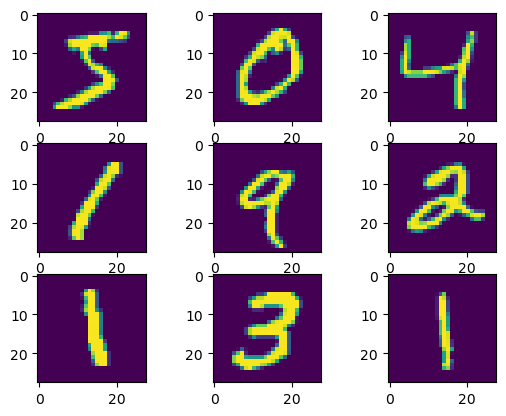

In [2]:
train_data = MNIST(root='./', train=True, download=True, transform=ToTensor())
test_data = MNIST(root='./', train=False, download=True, transform=ToTensor())

print(f'Load한 학습용 데이터 갯수 : {len(train_data)}')
print(f'Load한 검증용 데이터 갯수 : {len(test_data)}')

for idx in range(9):
    plt.subplot(3,3, idx+1)
    plt.imshow(train_data.data[idx])
plt.show()

# DataLoader Class를 이용해 이미지 묶음을 학습을 위한 
# batch_size 별로 나누거나 
# 랜덤하게 섞는다. (Shuffle)

In [3]:
from torch.utils.data.dataloader import DataLoader

loader_train = DataLoader(train_data, batch_size=32, shuffle=True)
loader_test = DataLoader(test_data, batch_size=32, shuffle=False) # 평가용 데이터는 섞을 필요가 없음.

# MNIST 는 객체에 rgb값 (data)와 정답 (label)이 이미 정해져있어 DataLoader로 Load하기만 하면 되는 것.

In [4]:
import torch
import torch.nn as nn
from torch.optim.adam import Adam
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = nn.Sequential(
    nn.Linear(784,64), # 다운받은 이미지가 28x28x1 (흑백이라서 마지막은 1) 의 픽셀을 갖고있어서 입력이 784개가 되는것
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64,10), # 마지막으로 0~9까지의 10 종류의 이미지를 구별하기에 10개의 출력을 가진다.
)

model.to(device) # 모델의 파라미터를 GPU로 전송

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)

In [5]:
lr = 1e-3
optim = Adam(model.parameters(), lr=lr)

for epoch in range(20):
    for data, label in loader_train:
        optim.zero_grad()
        
        data = torch.reshape(data, (-1, 784)).to(device) 
        # 연산을 위해 784px (28*28*1)을 한 줄로 펼친다.
        # data는 batch size만큼의 데이터가 들어있다. (여기서는 32개)
        # 따라서 기존의 32 * 28 * 28 * 1로 이루어져 있던 데이터를 32 * 784의 형태로 만드는 것이다.
        # 마지막 to(device)는 gpu로 보내기 위해 형태를 맞추는 것.
        predict = model(data)
        
        loss = nn.CrossEntropyLoss()(predict, label.to(device)) 
        # 크로스엔트로피 손실함수는 예측과 실제 값의 확률 분포를 가지고 만들어진 손실함수이다.
        loss.backward()
        optim.step()
        
    print(f'epoch({epoch+1}), loss:{loss.item()}')
    
torch.save(model.state_dict(), 'MNIST.pth') 
# 최종적으로 나온 모델의 가중치를 dictionary 형식으로 저장.
# 어떤 Layer : 가중치 값
# 형식의 dict 형태임.

epoch(1), loss:0.4908069968223572
epoch(2), loss:0.02524268440902233
epoch(3), loss:0.05531668663024902
epoch(4), loss:0.18687069416046143
epoch(5), loss:0.023533234372735023
epoch(6), loss:0.005612760782241821
epoch(7), loss:0.0018633641302585602
epoch(8), loss:0.030443118885159492
epoch(9), loss:0.0018469756469130516
epoch(10), loss:0.011200662702322006
epoch(11), loss:0.03943713754415512
epoch(12), loss:0.0006609653937630355
epoch(13), loss:0.004797263536602259
epoch(14), loss:0.0052544171921908855
epoch(15), loss:0.011079696007072926
epoch(16), loss:0.0007098098867572844
epoch(17), loss:0.2906653583049774
epoch(18), loss:0.0032399648334831
epoch(19), loss:0.020977942273020744
epoch(20), loss:0.00028014081181026995


In [23]:
model.load_state_dict(torch.load('MNIST.pth', map_location=device))
corr_num = 0


# 속도 개선을 위해 넣는 with문.
# 기울기 계산을 하지 않겠다고 명시적으로 선언.
# 선언하지않으면 각 Layer를 지날때마다 기울기 계산이 이뤄져 속도가 약간 느려지기 때문에
# 속도 향상을 목적으로 선언.
incorr_img = []

with torch.no_grad():
    for data, label in loader_test:
        data = torch.reshape(data, (-1, 784)).to(device)
        
        output = model(data.to(device))
        # output에는 기울기와 data 값이 같이 저장된다.
        out_predict = output.data.max(1)[1]
        # output에서 data 값을 가져와 특정 차원에서의 max 값을 찾는다. 세로로 묶어보냐 (0) 가로로 묶어보냐 (1)
        # max 값, index가 반환되는데 필요한건 index이므로 [1]
        
        corr_predict = out_predict.eq(label.to(device).data)
        # out_predict.eq(label.to(device).data) 는 batch_size(32)개의 데이터 중에서 맞은것 (True), 틀린것 (False)로 반환해줌.
        # True = 1, False = 0 이기에 전체 요소를 더하고 숫자만 뽑아내기 위해서 item()으로 추출. 
        # (다른 정보가 같이 들어있기 때문에 추출 필요)
        corr_num += corr_predict.sum().item()
        
        for idx, corr_data in enumerate(corr_predict): 
            # corr_predict 값 중에서 False 값의 index만 추출.
            # 그 index 값의 해당하는 img data value와 실제 정답(label)의 값을 dict 구조로 저장한다.
            if corr_data.item() == False:
                incorr_img.append({
                    'pred_idx' : out_predict[idx],
                    'pred_img_data' : data[idx].cpu().reshape(28, 28, 1),
                    'label_idx' : label[idx]
                })

        
    print(f'정확도 <{corr_num}/{len(test_data)}> : {corr_num / len(test_data) * 100}%')

정확도 <9749/10000> : 97.49%


오답 갯수 : 251
오답 이미지 Head 12개 출력


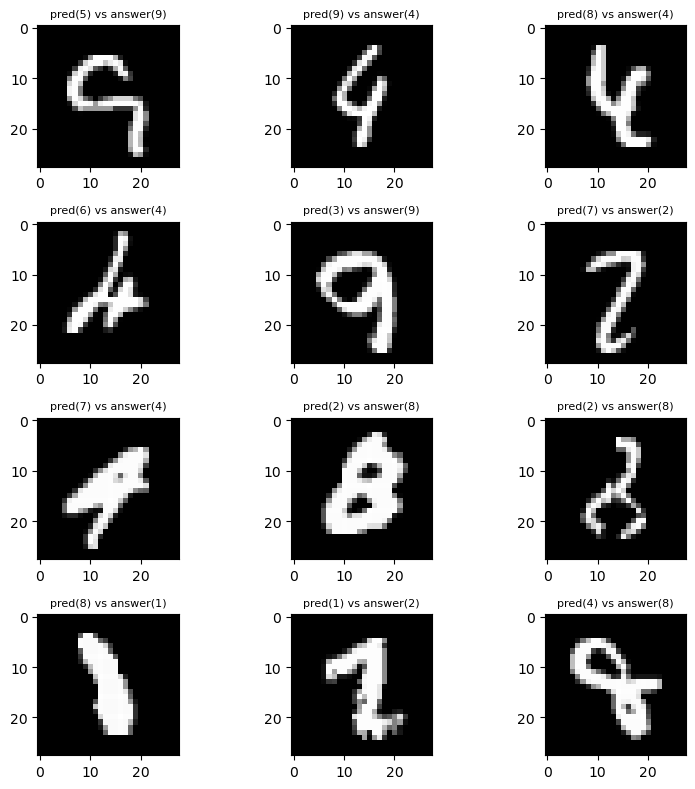

In [22]:
print(f'오답 갯수 : {len(incorr_img)}')
print('오답 이미지 Head 12개 출력')

fig, axs = plt.subplots(figsize=(8, 8), nrows=4, ncols=3, tight_layout=True)

for i in range(12):
    row = i // 3 
    col = i % 3
    axs[row, col].imshow(incorr_img[i]['pred_img_data'], cmap='gray')  
    axs[row, col].set_title(f'pred({incorr_img[i]["pred_idx"]}) vs answer({incorr_img[i]["label_idx"]})', fontsize=8)

plt.show()

# MLP 모델의 단점
- 전체 Pixel에 대한 가중치를 학습한다.
- 그래서 feature의 위치가 달라지거나 크기가 커지는 등 변화가 있으면 다른 이미지로 인식한다.

# MLP 모델의 단점을 극복하기 위해 CNN 모델을 다음으로 공부한다